## Finetune Mask RCNN baseline comparison model

### **Install Detectron2**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15737, done.
remote: Counting objects: 100% (460/460), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 15737 (delta 211), reused 305 (delta 118), pack-reused 15277
Receiving objects: 100% (15737/15737), 6.52 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (11326/11326), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:0

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets.

Our dataset has been preprocessed into coco format where we have a single JSON file that describes all the annotations from all training images. <p>

Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



We have preprocessed our images into a coco json format in the preprocessing notebook. So we just import them directly here

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/train/coco_annotations.json", "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/val/coco_annotations.json", "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/val")

Let us extract the metadata and dataset dictionaries for both training and validation datasets.

In [6]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[06/24 00:43:36 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/train/coco_annotations.json takes 2.33 seconds.
[06/24 00:43:36 d2.data.datasets.coco]: Loaded 135 images in COCO format from /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/train/coco_annotations.json


In [7]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[06/24 00:43:38 d2.data.datasets.coco]: Loaded 15 images in COCO format from /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/COCO_dataset/val/coco_annotations.json


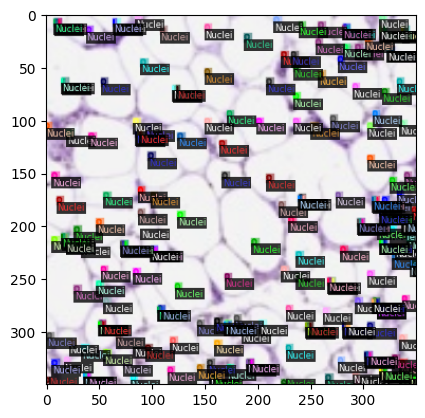

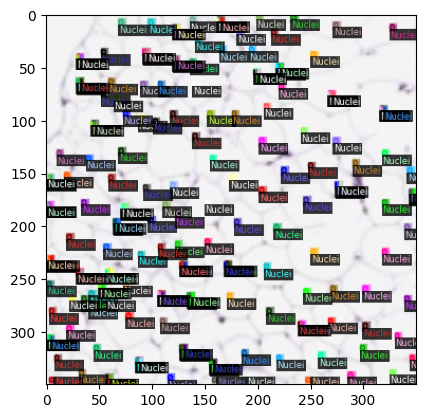

In [8]:
from matplotlib import pyplot as plt
# Visualize a random sample
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model training.

For the purpose of our fine-tuning, we use the default settings mostly. Main modifications is the number of classes.

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes, nuclei
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given configuration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[06/24 00:43:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 140MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [10]:
trainer.train() #Start the training process

[06/24 00:44:02 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:44:18 d2.utils.events]:  eta: 0:04:24  iter: 19  total_loss: 9.344  loss_cls: 0.686  loss_box_reg: 0.01711  loss_mask: 0.6938  loss_rpn_cls: 6.718  loss_rpn_loc: 1.271    time: 0.5665  last_time: 0.6320  data_time: 0.0451  last_data_time: 0.0516   lr: 9.7405e-06  max_mem: 2385M
[06/24 00:44:35 d2.utils.events]:  eta: 0:04:06  iter: 39  total_loss: 4.036  loss_cls: 0.6869  loss_box_reg: 0.009139  loss_mask: 0.6932  loss_rpn_cls: 1.439  loss_rpn_loc: 1.183    time: 0.5491  last_time: 0.4780  data_time: 0.0192  last_data_time: 0.0078   lr: 1.9731e-05  max_mem: 2537M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:44:46 d2.utils.events]:  eta: 0:03:55  iter: 59  total_loss: 2.641  loss_cls: 0.5207  loss_box_reg: 0.01526  loss_mask: 0.6925  loss_rpn_cls: 0.7251  loss_rpn_loc: 0.7229    time: 0.5512  last_time: 0.5893  data_time: 0.0210  last_data_time: 0.0269   lr: 2.972e-05  max_mem: 2937M
[06/24 00:44:59 d2.utils.events]:  eta: 0:03:47  iter: 79  total_loss: 2.335  loss_cls: 0.5047  loss_box_reg: 0.01462  loss_mask: 0.6911  loss_rpn_cls: 0.5662  loss_rpn_loc: 0.5548    time: 0.5710  last_time: 0.5190  data_time: 0.0265  last_data_time: 0.0225   lr: 3.9711e-05  max_mem: 2937M
[06/24 00:45:10 d2.utils.events]:  eta: 0:03:37  iter: 99  total_loss: 2.128  loss_cls: 0.4954  loss_box_reg: 0.03352  loss_mask: 0.6892  loss_rpn_cls: 0.4876  loss_rpn_loc: 0.4156    time: 0.5687  last_time: 0.6163  data_time: 0.0175  last_data_time: 0.0220   lr: 4.9701e-05  max_mem: 2937M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:45:20 d2.utils.events]:  eta: 0:03:24  iter: 119  total_loss: 2.066  loss_cls: 0.4946  loss_box_reg: 0.06154  loss_mask: 0.6869  loss_rpn_cls: 0.4626  loss_rpn_loc: 0.3642    time: 0.5602  last_time: 0.4949  data_time: 0.0130  last_data_time: 0.0145   lr: 5.9691e-05  max_mem: 2937M
[06/24 00:45:31 d2.utils.events]:  eta: 0:03:14  iter: 139  total_loss: 2.049  loss_cls: 0.4958  loss_box_reg: 0.08579  loss_mask: 0.684  loss_rpn_cls: 0.4424  loss_rpn_loc: 0.3384    time: 0.5601  last_time: 0.5569  data_time: 0.0152  last_data_time: 0.0193   lr: 6.9681e-05  max_mem: 2937M
[06/24 00:45:43 d2.utils.events]:  eta: 0:03:04  iter: 159  total_loss: 2.048  loss_cls: 0.5163  loss_box_reg: 0.1303  loss_mask: 0.6794  loss_rpn_cls: 0.4009  loss_rpn_loc: 0.335    time: 0.5605  last_time: 0.5563  data_time: 0.0130  last_data_time: 0.0154   lr: 7.9671e-05  max_mem: 2937M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:45:54 d2.utils.events]:  eta: 0:02:52  iter: 179  total_loss: 2.057  loss_cls: 0.5229  loss_box_reg: 0.1519  loss_mask: 0.6753  loss_rpn_cls: 0.3882  loss_rpn_loc: 0.3107    time: 0.5594  last_time: 0.6771  data_time: 0.0139  last_data_time: 0.0248   lr: 8.966e-05  max_mem: 2937M
[06/24 00:46:05 d2.utils.events]:  eta: 0:02:41  iter: 199  total_loss: 2.041  loss_cls: 0.5234  loss_box_reg: 0.1781  loss_mask: 0.6683  loss_rpn_cls: 0.3583  loss_rpn_loc: 0.312    time: 0.5582  last_time: 0.5158  data_time: 0.0126  last_data_time: 0.0113   lr: 9.9651e-05  max_mem: 2937M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:46:16 d2.utils.events]:  eta: 0:02:31  iter: 219  total_loss: 2.032  loss_cls: 0.5094  loss_box_reg: 0.1789  loss_mask: 0.6607  loss_rpn_cls: 0.3713  loss_rpn_loc: 0.311    time: 0.5586  last_time: 0.5524  data_time: 0.0145  last_data_time: 0.0154   lr: 0.00010964  max_mem: 2937M
[06/24 00:46:28 d2.utils.events]:  eta: 0:02:21  iter: 239  total_loss: 1.988  loss_cls: 0.509  loss_box_reg: 0.1695  loss_mask: 0.6471  loss_rpn_cls: 0.3652  loss_rpn_loc: 0.2967    time: 0.5630  last_time: 0.5732  data_time: 0.0192  last_data_time: 0.0131   lr: 0.00011963  max_mem: 2937M
[06/24 00:46:40 d2.utils.events]:  eta: 0:02:11  iter: 259  total_loss: 1.971  loss_cls: 0.5079  loss_box_reg: 0.2016  loss_mask: 0.6314  loss_rpn_cls: 0.3444  loss_rpn_loc: 0.2904    time: 0.5640  last_time: 0.6556  data_time: 0.0151  last_data_time: 0.0292   lr: 0.00012962  max_mem: 2937M
[06/24 00:46:51 d2.utils.events]:  eta: 0:02:00  iter: 279  total_loss: 1.952  loss_cls: 0.5091  loss_box_reg: 0.2245  loss_ma

/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:47:24 d2.utils.events]:  eta: 0:01:28  iter: 339  total_loss: 1.887  loss_cls: 0.5108  loss_box_reg: 0.2196  loss_mask: 0.5703  loss_rpn_cls: 0.3162  loss_rpn_loc: 0.277    time: 0.5624  last_time: 0.5459  data_time: 0.0141  last_data_time: 0.0076   lr: 0.00016958  max_mem: 2937M
[06/24 00:47:35 d2.utils.events]:  eta: 0:01:17  iter: 359  total_loss: 1.893  loss_cls: 0.5001  loss_box_reg: 0.2309  loss_mask: 0.5694  loss_rpn_cls: 0.3192  loss_rpn_loc: 0.2714    time: 0.5614  last_time: 0.6157  data_time: 0.0125  last_data_time: 0.0095   lr: 0.00017957  max_mem: 2937M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:47:46 d2.utils.events]:  eta: 0:01:05  iter: 379  total_loss: 1.926  loss_cls: 0.519  loss_box_reg: 0.2383  loss_mask: 0.582  loss_rpn_cls: 0.3199  loss_rpn_loc: 0.2722    time: 0.5611  last_time: 0.5460  data_time: 0.0143  last_data_time: 0.0156   lr: 0.00018956  max_mem: 2937M
[06/24 00:47:58 d2.utils.events]:  eta: 0:00:54  iter: 399  total_loss: 1.874  loss_cls: 0.5032  loss_box_reg: 0.2324  loss_mask: 0.5668  loss_rpn_cls: 0.3174  loss_rpn_loc: 0.262    time: 0.5609  last_time: 0.5061  data_time: 0.0157  last_data_time: 0.0080   lr: 0.00019955  max_mem: 2937M
[06/24 00:48:09 d2.utils.events]:  eta: 0:00:44  iter: 419  total_loss: 1.846  loss_cls: 0.4903  loss_box_reg: 0.2127  loss_mask: 0.5663  loss_rpn_cls: 0.3065  loss_rpn_loc: 0.25    time: 0.5614  last_time: 0.5561  data_time: 0.0125  last_data_time: 0.0087   lr: 0.00020954  max_mem: 2937M
[06/24 00:48:20 d2.utils.events]:  eta: 0:00:32  iter: 439  total_loss: 1.862  loss_cls: 0.4959  loss_box_reg: 0.2247  loss_mask:

/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/24 00:48:43 d2.utils.events]:  eta: 0:00:11  iter: 479  total_loss: 1.85  loss_cls: 0.4917  loss_box_reg: 0.246  loss_mask: 0.5613  loss_rpn_cls: 0.2953  loss_rpn_loc: 0.2521    time: 0.5616  last_time: 0.4844  data_time: 0.0142  last_data_time: 0.0085   lr: 0.00023951  max_mem: 2937M
[06/24 00:49:02 d2.utils.events]:  eta: 0:00:00  iter: 499  total_loss: 1.834  loss_cls: 0.4784  loss_box_reg: 0.2489  loss_mask: 0.561  loss_rpn_cls: 0.296  loss_rpn_loc: 0.2613    time: 0.5617  last_time: 0.5107  data_time: 0.0146  last_data_time: 0.0091   lr: 0.0002495  max_mem: 2937M
[06/24 00:49:02 d2.engine.hooks]: Overall training speed: 498 iterations in 0:04:39 (0.5618 s / it)
[06/24 00:49:02 d2.engine.hooks]: Total training time: 0:04:53 (0:00:14 on hooks)


Save the config file

In [11]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [12]:
# Inference should use the config with parameters that are used in training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20   # set a custom testing threshold. We tried 10, 20, 30, 40, 50; 20 had the best performance.
cfg.TEST.DETECTIONS_PER_IMAGE = 2000  # Set the maximum number of detections per image to 2000 (this accomodate our image context well. The most dense image in our dataset is not up to 1000 cells)
predictor = DefaultPredictor(cfg)

[06/24 00:49:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


#### Verify segmentation on random validation images

/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


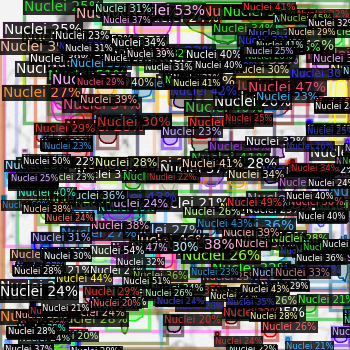

In [13]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

###**Load a Test image and segment it.**

[06/24 00:49:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


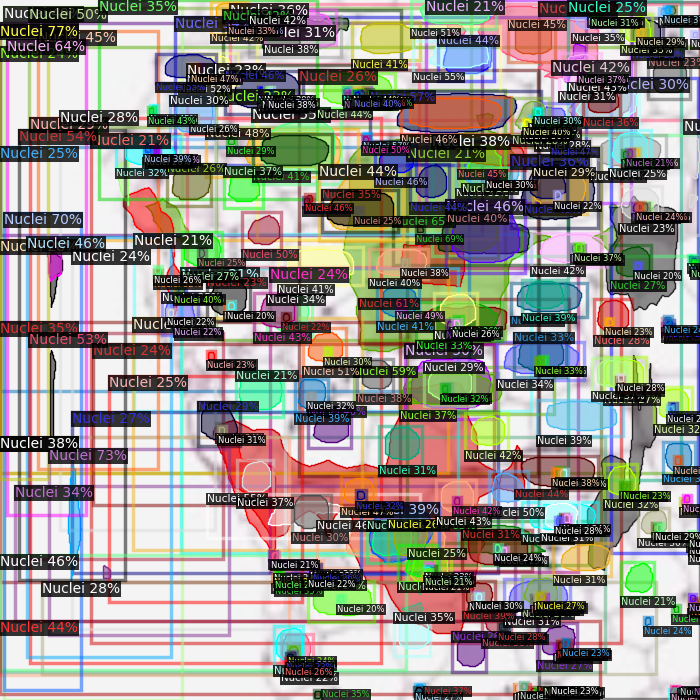

Number of instance predictions: 368


In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20   # set a custom testing threshold. We tried 10, 20, 30, 40, 50; The performance deteriorates after 20.
cfg.TEST.DETECTIONS_PER_IMAGE = 2000

predictor = DefaultPredictor(cfg)

new_im = cv2.imread("/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/ADC/Test/images/27200-20400_GTEX-18D9U_Adipose-Subcutaneous.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

# Get the instance predictions
instances = outputs["instances"]

# Get the number of instance predictions
num_predictions = len(instances)

print("Number of instance predictions:", num_predictions)

# print(outputs["instances"].pred_classes)
#print(outputs["instances"].pred_boxes)

###**Process multiple images in a directory and save the results in an output directory**

In [15]:

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/ADC/Test/images"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/Test Results/test_segmentation_output"

# Create the output folder if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

Segmentation of all images completed.



###**Segment images and save object level information into a csv file.**




In [16]:
import csv
from skimage.measure import regionprops, label

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/ADC/Test/images"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv"

# Extract the directory name from the full path
output_dir_name = os.path.dirname(output_csv_path)

# Check if the directory exists
if not os.path.exists(output_dir_name):
    # If not, create the directory
    os.makedirs(output_dir_name)


# List of valid image extensions.
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        # Check if the file has a valid image extension
        if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
            continue

        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)

        # Check if any regions are detected
        if np.any(labeled_mask):
            props = regionprops(labeled_mask)

            # Write the object-level information to the CSV file
            for i, prop in enumerate(props):
                object_number = i + 1
                area = prop.area
                centroid = prop.centroid
                bounding_box = prop.bbox

                # Check if the corresponding class label exists
                if i < len(class_labels):
                    class_label = class_labels[i]
                    class_name = train_metadata.thing_classes[class_label]
                else:
                    class_name = 'Unknown'

                csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])
        else:
            # Handle case where no regions are detected (empty mask)
            # Populate CSV with default information for one object
            default_object_number = 1
            default_area = 0  #
            default_centroid = (0, 0)  #
            default_bounding_box = (0, 0, 0, 0)  #
            default_class_name = 'Unknown'

            csvwriter.writerow([image_filename, default_class_name, default_object_number, default_area, default_centroid, default_bounding_box])

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


###**Generate plots to visualize the density of segmented cells across the images**

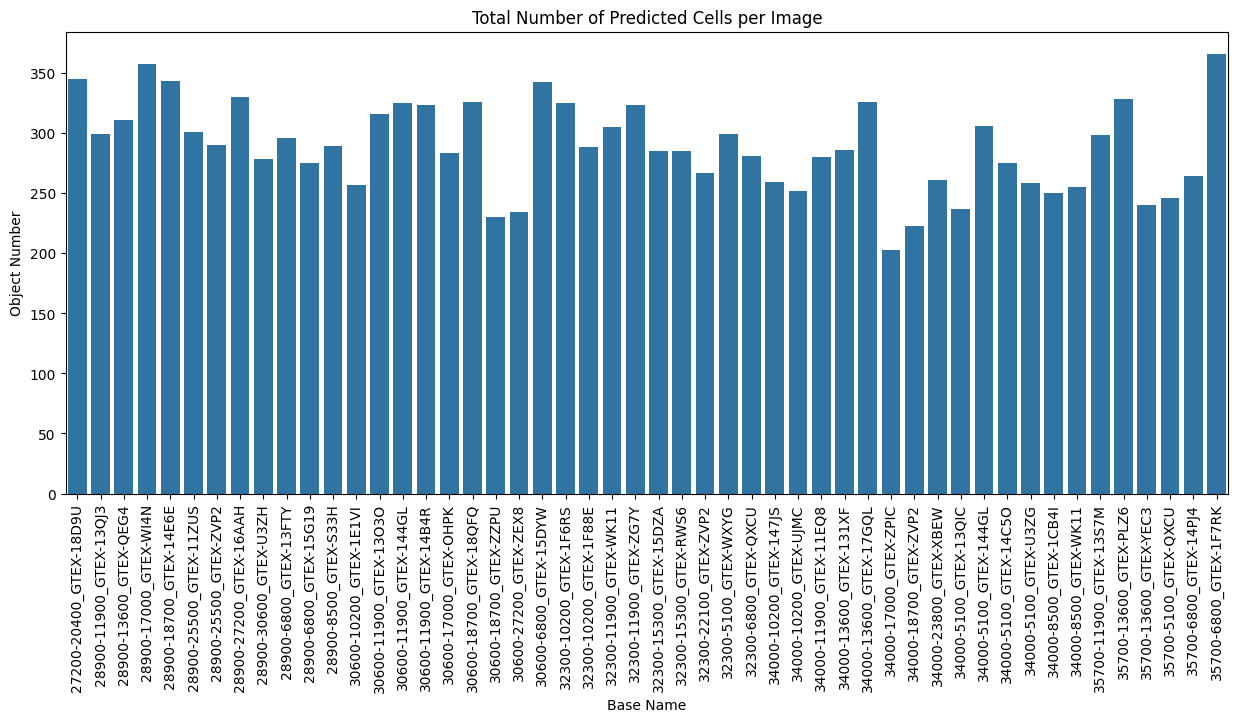

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv")

# 1. number of Nuclei per image for each unique 'File Name'.
# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', n=1).str[0]

# Group by the base name and compute the total number of non-empty object numbers per image
total_nuclei_per_base_name = df.groupby('Base Name')['Object Number'].apply(lambda x: (x != 0).sum()).reset_index()

# Plot the total number of non-empty object numbers per image
plt.figure(figsize=(15, 6))
sns.barplot(data=total_nuclei_per_base_name, x='Base Name', y='Object Number')
plt.title('Total Number of Predicted Cells per Image')
plt.xticks(rotation=90)
plt.show()


### Now let's analyze the predictions, compare it to ground truths, and save the prediction summary in an excel file

In [20]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv")

# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', n=1).str[0]

# Group by the base name and compute the total number of non-empty object numbers per image
total_nuclei_per_base_name = df.groupby('File Name')['Object Number'].apply(lambda x: (x != 0).sum()).reset_index()
total_nuclei_per_base_name.columns = ['File Name', 'Total Nuclei']

# Load the ground truth Excel file
ground_truth_df = pd.read_csv('/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/ADC/ground_truth.csv')

# Merge the total nuclei counts with the ground truth data
merged_df = pd.merge(total_nuclei_per_base_name, ground_truth_df, left_on='File Name', right_on='image name')

# Calculate the absolute difference and absolute percentage accuracy
merged_df['Absolute Difference'] = (merged_df['Total Nuclei'] - merged_df['ground truth']).abs()
merged_df['Absolute Percentage Accuracy'] = (1 - merged_df['Absolute Difference'] / merged_df['ground truth']) * 100

# Rename columns and create the new column "AAE <=10"
merged_df.rename(columns={'Total Nuclei': 'Prediction', 'Absolute Difference': 'Raw Absolute Error'}, inplace=True)
merged_df['AAE <=10'] = merged_df['Raw Absolute Error'].apply(lambda x: 'Yes' if x <= 10 else 'No')

# Drop unnecessary columns
merged_df.drop(columns=['image name'], inplace=True)

# Reorder columns
final_df = merged_df[['File Name', 'ground truth', 'Prediction', 'Raw Absolute Error', 'AAE <=10']]
final_df.rename(columns={'ground truth avg': 'Ground Truth', 'File Name': 'Image Name'}, inplace=True)
final_df = final_df.sort_values(by='Raw Absolute Error', ascending=True)

# Save the final DataFrame to a new prediction summary Excel file
summary_excel_path = '/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/ADC/Mask RCNN/Mask RCNN_prediction_summary_ADC.xlsx'
final_df.to_excel(summary_excel_path, index=False)

# Display the final DataFrame
print(final_df)


<ipython-input-20-548e9b341562>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'ground truth avg': 'Ground Truth', 'File Name': 'Image Name'}, inplace=True)


                                         Image Name  ground truth  Prediction  \
31   34000-10200_GTEX-UJMC_Adipose-Subcutaneous.png           267         252   
35   34000-17000_GTEX-ZPIC_Adipose-Subcutaneous.png           164         203   
22  32300-10200_GTEX-1F88E_Adipose-Subcutaneous.png           241         288   
19   30600-27200_GTEX-ZEX8_Adipose-Subcutaneous.png           187         234   
37   34000-23800_GTEX-XBEW_Adipose-Subcutaneous.png           208         261   
25  32300-15300_GTEX-15DZA_Adipose-Subcutaneous.png           218         285   
36   34000-18700_GTEX-ZVP2_Adipose-Subcutaneous.png           152         223   
12  30600-10200_GTEX-1E1VI_Adipose-Subcutaneous.png           172         257   
16   30600-17000_GTEX-OHPK_Adipose-Subcutaneous.png           197         283   
38   34000-5100_GTEX-13QIC_Adipose-Subcutaneous.png           147         237   
18   30600-18700_GTEX-ZZPU_Adipose-Subcutaneous.png           139         230   
30  34000-10200_GTEX-147JS_A

# END